### E28 Anomaly Detection with GAN

- 학습목표 
    - 이상(Anomaly) 데이터가 부족한 상황에서 GAN을 이용해 이미지 이상감지 모델을 구축하는 논리를 파악한다. 
    - Skip-GANomaly 모델 및 Loss 함수를 구현해 본다. 
    - 간단한 데이터셋을 이용해 Skip-GANomaly 의 이상감지 효과를 파악해 본다. 

In [83]:
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display
from PIL import Image

#### 1. 이상감지 데이터셋 구축 
 ##### 1.1 데이터 전처리

In [84]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

print(train_data.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

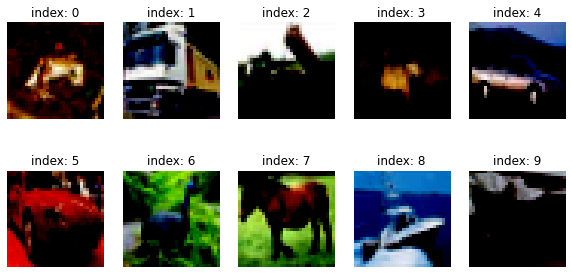

In [85]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

- frog label 제거

In [86]:
def set_labels(labels):
    new_labels = []
    for old_label in labels:
        if old_label ==  6:
            new_labels.append([0])
        else:
            new_labels.append([1])
            
    return np.array(new_labels)

In [87]:
new_train_labels = set_labels(train_labels)
new_test_labels = set_labels(test_labels)

In [88]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, new_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [89]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [90]:
train_data = normal_data
new_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
new_test_labels = tf.concat([new_test_labels, anomaly_labels], 0)

print(train_data.shape)
print(test_data.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)


In [91]:
for label in new_train_labels:
    if label == 0:
        print(label)
print('Done')

Done


In [92]:
BUFFER_SIZE = 15000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, new_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, new_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [93]:
for data, label in train_dataset.take(1):
    print(label)
for data, label in test_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)
tf.Tensor(
[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]], shape=(8, 1), dtype=int64)


#### 2. 모델 구현

In [94]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False, kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [95]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False, kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [96]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel=3):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64)
        self.encoder_2 = Conv_block(128)
        self.encoder_3 = Conv_block(256)
        self.encoder_4 = Conv_block(512)
        
        self.center = Conv_block(512)
        
        self.decoder_4 = Conv_T_block(512)
        self.decoder_3 = Conv_T_block(256)
        self.decoder_2 = Conv_T_block(128)
        self.decoder_1 = Conv_T_block(64)
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2, padding='same', use_bias=False, kernel_initializer=tf.random_normal_initializer(0., 0.02))
        
    def call(self, inputs, trainig=False):
        en_1 = self.encoder_1(inputs)
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs
        

In [97]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64)
        self.encoder_2 = Conv_block(128)
        self.encoder_3 = Conv_block(256)
        self.encoder_4 = Conv_block(512)
        
        self.center = Conv_block(100)
        
        self.outputs = layers.Conv2D(1, 3, strides =1, padding='same', use_bias=False, activation='sigmoid')
        
    def call(self, inputs, training=False):
        en_1 =self.encoder_1(inputs)
        en_2 =self.encoder_2(en_1)
        en_3 =self.encoder_3(en_2)
        en_4 =self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

In [98]:
generator = Generator(num_output_channel=3)
discriminator = Discriminator()

In [99]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

In [100]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + w_context * context_loss + w_encoder * encoder_loss
    
    return total_gen_loss

In [101]:
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

In [102]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(pred_real, pred_fake, images, generated_images, feat_real, feat_fake)
        
        disc_loss = discriminator_loss(pred_real, pred_fake)
        
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [103]:
checkpoint_path = os.path.join(os.getenv('HOME'), 'aiffel/ganomaly_skip_no_norm/ckpt/')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
    
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, 
                                discriminator_optimizer=discriminator_optimizer,
                                generator = generator,
                                discriminator=discriminator
                                )

#### 3. 모델 학습

In [104]:
max_epochs = 25
steps = 0

for epoch in range(max_epochs):
    start = time.time()
    
    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print(f'Steps : {steps}, \t Total Gen Loss : {gen_loss.numpy()}, \t Total Dis Loss : {disc_loss.numpy()}')
            
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix=checkpoint_path)
            
    print(f'Time for epoch {epoch+1} is {time.time() - start} sec')




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Steps : 100, 	 T

In [105]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

#### 4. 평가 및 시각화

In [111]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)
        
        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()
        
        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2
        
        rec = tf.reduce_sum(rec, [1, 2, 3])
        lat = tf.reduce_sum(lat, [1, 2, 3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    
    
    return an_scores, gt_labels

In [112]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

15000 15000


In [113]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)
        
normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(6000,)


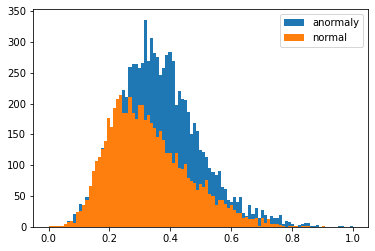

In [126]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.legend(['anormaly', 'normal'])
plt.show()

0.365144 0.328994
0.13412721 0.13204196


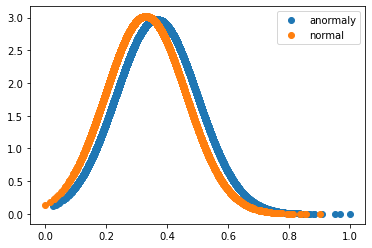

In [127]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')
plt.legend(['anormaly', 'normal'])

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))